In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read the given datasets
df_rt = pd.read_csv('ABS_RT.csv')
df_cpi = pd.read_csv('ABS_CPI_1.1.0.csv')

In [3]:
# From observing the datasets, we can see some variables which might not contribute to the analysis.
# Hence, we drop unnecessary variables

columns_to_drop_rt = ['DATAFLOW', 'MEASURE: Measure', 'TSEST: Adjustment Type', 'UNIT_MEASURE: Unit of Measure', 'UNIT_MULT: Unit of Multiplier', 'OBS_STATUS: Observation Status', 'OBS_COMMENT: Observation Comment']
df_rt = df_rt.drop(columns=columns_to_drop_rt)

columns_to_drop_cpi = ['DATAFLOW', 'MEASURE: Measure', 'TSEST: Adjustment Type', 'UNIT_MEASURE: Unit of Measure', 'OBS_STATUS: Observation Status', 'OBS_COMMENT: Observation Comment']
df_cpi = df_cpi.drop(columns=columns_to_drop_cpi)

In [4]:
df_rt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7693 entries, 0 to 7692
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   INDUSTRY: Industry        7693 non-null   object 
 1   REGION: Region            7693 non-null   object 
 2   FREQ: Frequency           7693 non-null   object 
 3   TIME_PERIOD: Time Period  7693 non-null   object 
 4   OBS_VALUE                 7376 non-null   float64
dtypes: float64(1), object(4)
memory usage: 300.6+ KB


In [5]:
df_cpi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4536 entries, 0 to 4535
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   INDEX: Index              4536 non-null   object 
 1   REGION: Region            4536 non-null   object 
 2   FREQ: Frequency           4536 non-null   object 
 3   TIME_PERIOD: Time Period  4536 non-null   object 
 4   OBS_VALUE                 4536 non-null   float64
 5   DECIMALS: Decimals        4536 non-null   object 
dtypes: float64(1), object(5)
memory usage: 212.8+ KB


In [6]:
# Then, we check for missing variables from 2 datasets
print(df_rt.isnull().sum(),'\n')

print(df_cpi.isnull().sum())

INDUSTRY: Industry            0
REGION: Region                0
FREQ: Frequency               0
TIME_PERIOD: Time Period      0
OBS_VALUE                   317
dtype: int64 

INDEX: Index                0
REGION: Region              0
FREQ: Frequency             0
TIME_PERIOD: Time Period    0
OBS_VALUE                   0
DECIMALS: Decimals          0
dtype: int64


# Data Cleaning

In [7]:
df_rt[df_rt['OBS_VALUE'].isnull()]

,INDUSTRY: Industry,REGION: Region,FREQ: Frequency,TIME_PERIOD: Time Period,OBS_VALUE
314,44: Department stores,6: Tasmania,M: Monthly,2010-07,NaN
315,44: Department stores,6: Tasmania,M: Monthly,2010-08,NaN
316,44: Department stores,6: Tasmania,M: Monthly,2010-09,NaN
317,44: Department stores,6: Tasmania,M: Monthly,2010-10,NaN
318,44: Department stores,6: Tasmania,M: Monthly,2010-11,NaN
...,...,...,...,...,...
7688,"43: Clothing, footwear and personal accessory ...",6: Tasmania,M: Monthly,2023-03,NaN
7689,"43: Clothing, footwear and personal accessory ...",6: Tasmania,M: Monthly,2023-04,NaN
7690,"43: Clothing, footwear and personal accessory ...",6: Tasmania,M: Monthly,2023-05,NaN
7691,"43: Clothing, footwear and personal accessory ...",6: Tasmania,M: Monthly,2023-06,NaN


In [8]:
# Once we check the missing variables, we investigate further and found that most of the missing variables 
# are from Tasmania, we apply imputation techniques by using INDUSTRY's mean of OBS_VALUE, group by REGION 

# Filter the missing values that have REGION: Region = Tasmania
missing_in_tasmania = df_rt[(df_rt['REGION: Region'] == '6: Tasmania') & df_rt['OBS_VALUE'].isnull()]

# Impute missing values
for index, row in missing_in_tasmania.iterrows():
    industry = row['INDUSTRY: Industry']
    industry_mean = df_rt[(df_rt['REGION: Region'] == '6: Tasmania') & (df_rt['INDUSTRY: Industry'] == industry)]['OBS_VALUE'].mean()
    df_rt.at[index, 'OBS_VALUE'] = industry_mean

In [9]:
# We check for missing variables again
df_rt.isnull().sum()

INDUSTRY: Industry            0
REGION: Region                0
FREQ: Frequency               0
TIME_PERIOD: Time Period      0
OBS_VALUE                   157
dtype: int64

In [10]:
# We can see that there are still missing variables 
df_rt[df_rt['OBS_VALUE'].isnull()]

,INDUSTRY: Industry,REGION: Region,FREQ: Frequency,TIME_PERIOD: Time Period,OBS_VALUE
314,44: Department stores,6: Tasmania,M: Monthly,2010-07,NaN
315,44: Department stores,6: Tasmania,M: Monthly,2010-08,NaN
316,44: Department stores,6: Tasmania,M: Monthly,2010-09,NaN
317,44: Department stores,6: Tasmania,M: Monthly,2010-10,NaN
318,44: Department stores,6: Tasmania,M: Monthly,2010-11,NaN
...,...,...,...,...,...
466,44: Department stores,6: Tasmania,M: Monthly,2023-03,NaN
467,44: Department stores,6: Tasmania,M: Monthly,2023-04,NaN
468,44: Department stores,6: Tasmania,M: Monthly,2023-05,NaN
469,44: Department stores,6: Tasmania,M: Monthly,2023-06,NaN


In [11]:
# We impute the rest of missing variables with the mean of the industry

# Calculate the mean of OBS_VALUE for each industry
industry_means = df_rt.groupby(['INDUSTRY: Industry'])['OBS_VALUE'].mean().reset_index()

# Create a dictionary to map industry to its mean
industry_mean_dict = dict(zip(industry_means['INDUSTRY: Industry'], industry_means['OBS_VALUE']))

# Function to impute missing values using the mean of the industry
def impute_missing(row):
    if pd.isna(row['OBS_VALUE']):
        return industry_mean_dict.get(row['INDUSTRY: Industry'], row['OBS_VALUE'])
    else:
        return row['OBS_VALUE']

# Apply the impute_missing function to fill missing values
df_rt['OBS_VALUE'] = df_rt.apply(impute_missing, axis=1)

In [12]:
df_rt

,INDUSTRY: Industry,REGION: Region,FREQ: Frequency,TIME_PERIOD: Time Period,OBS_VALUE
0,20: Total,4: South Australia,M: Monthly,2010-07,1449.500000
1,20: Total,4: South Australia,M: Monthly,2010-08,1398.900000
2,20: Total,4: South Australia,M: Monthly,2010-09,1396.500000
3,20: Total,4: South Australia,M: Monthly,2010-10,1475.400000
4,20: Total,4: South Australia,M: Monthly,2010-11,1494.500000
...,...,...,...,...,...
7688,"43: Clothing, footwear and personal accessory ...",6: Tasmania,M: Monthly,2023-03,30.668148
7689,"43: Clothing, footwear and personal accessory ...",6: Tasmania,M: Monthly,2023-04,30.668148
7690,"43: Clothing, footwear and personal accessory ...",6: Tasmania,M: Monthly,2023-05,30.668148
7691,"43: Clothing, footwear and personal accessory ...",6: Tasmania,M: Monthly,2023-06,30.668148


In [13]:
# check for missing variables
df_rt.isnull().sum()

INDUSTRY: Industry          0
REGION: Region              0
FREQ: Frequency             0
TIME_PERIOD: Time Period    0
OBS_VALUE                   0
dtype: int64

In [14]:
df_rt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7693 entries, 0 to 7692
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   INDUSTRY: Industry        7693 non-null   object 
 1   REGION: Region            7693 non-null   object 
 2   FREQ: Frequency           7693 non-null   object 
 3   TIME_PERIOD: Time Period  7693 non-null   object 
 4   OBS_VALUE                 7693 non-null   float64
dtypes: float64(1), object(4)
memory usage: 300.6+ KB


# EDA

In [15]:
# 1. Summary Statistics
df_rt.describe()

,OBS_VALUE
count,7693.000000
mean,2117.521632
std,4193.845132
min,9.300000
25%,295.200000
50%,732.500000
75%,2014.300000
max,43982.100000


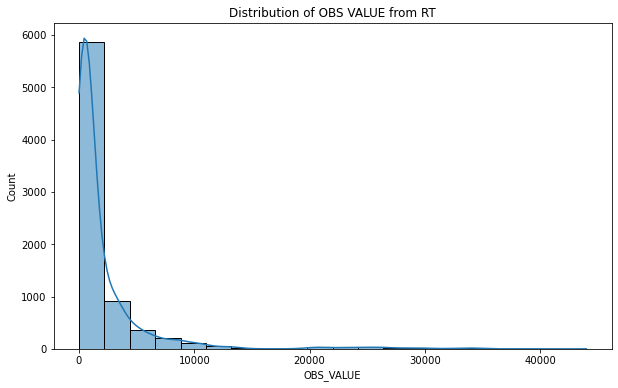

In [16]:
# 2. Find out distribution of OBS Value from RT
plt.figure(figsize=(10, 6))
sns.histplot(df_rt['OBS_VALUE'], bins=20, kde=True)
plt.title('Distribution of OBS VALUE from RT')
plt.xlabel('OBS_VALUE')
plt.show()

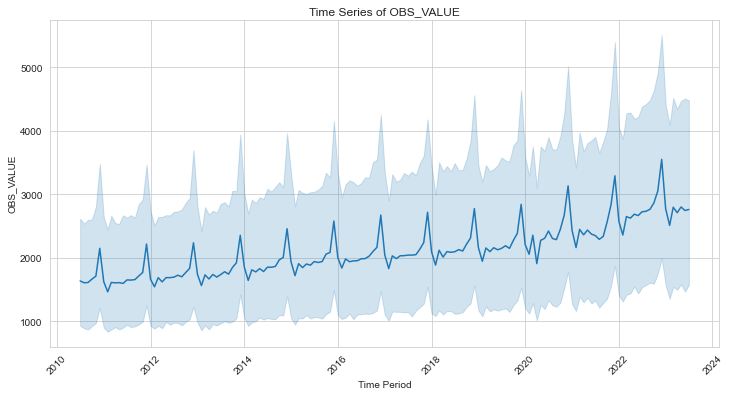

In [17]:
# 3. Investigate if there is any pattern in the OBS value through time
# Convert the 'TIME_PERIOD: Time Period' column to a datetime data type to make sure it is in proper format
df_rt['TIME_PERIOD: Time Period'] = pd.to_datetime(df_rt['TIME_PERIOD: Time Period'])

# Sort the DataFrame by the time period to ensure the data is in chronological order.
df_rt = df_rt.sort_values('TIME_PERIOD: Time Period')

# Set the figure size and style for the plot
plt.figure(figsize=(12, 6))
sns.set_style('whitegrid')

# Create the time series plot
sns.lineplot(data=df_rt, x='TIME_PERIOD: Time Period', y='OBS_VALUE')
plt.title('Time Series of OBS_VALUE')
plt.xlabel('Time Period')
plt.ylabel('OBS_VALUE')

# Rotate x-axis labels for readability (optional)
plt.xticks(rotation=45)

# Show the plot
plt.show()

### Question 2


In [18]:
df_rt

,INDUSTRY: Industry,REGION: Region,FREQ: Frequency,TIME_PERIOD: Time Period,OBS_VALUE
0,20: Total,4: South Australia,M: Monthly,2010-07-01,1449.500000
4710,41: Food retailing,4: South Australia,M: Monthly,2010-07-01,591.600000
2983,"46: Cafes, restaurants and takeaway food services",1: New South Wales,M: Monthly,2010-07-01,891.900000
785,45: Other retailing,2: Victoria,M: Monthly,2010-07-01,792.700000
6908,20: Total,AUS: Australia,M: Monthly,2010-07-01,20231.600000
...,...,...,...,...,...
6279,42: Household goods retailing,1: New South Wales,M: Monthly,2023-07-01,1675.200000
4395,20: Total,1: New South Wales,M: Monthly,2023-07-01,10591.200000
2982,44: Department stores,5: Western Australia,M: Monthly,2023-07-01,206.200000
5337,45: Other retailing,1: New South Wales,M: Monthly,2023-07-01,1575.500000


In [19]:
# Create a mapping from regions to capital cities
capital_cities = {
    "4: South Australia": "4: Adelaide",
    "2: Victoria": "2: Melbourne",
    "6: Tasmania": "6: Hobart",
    "5: Western Australia": "5: Perth",
    "3: Queensland": "3: Brisbane",
    "1: New South Wales": "1: Sydney"  
}

# Function to map region codes to capital cities
def map_region_to_city(region):
    return capital_cities.get(region, region)  # Use the region itself if not found

# Create a new column "CAPITAL_CITY" based on the mapping
df_rt["CAPITAL_CITY"] = df_rt["REGION: Region"].apply(map_region_to_city)

# Display the resulting DataFrame
df_rt

,INDUSTRY: Industry,REGION: Region,FREQ: Frequency,TIME_PERIOD: Time Period,OBS_VALUE,CAPITAL_CITY
0,20: Total,4: South Australia,M: Monthly,2010-07-01,1449.500000,4: Adelaide
4710,41: Food retailing,4: South Australia,M: Monthly,2010-07-01,591.600000,4: Adelaide
2983,"46: Cafes, restaurants and takeaway food services",1: New South Wales,M: Monthly,2010-07-01,891.900000,1: Sydney
785,45: Other retailing,2: Victoria,M: Monthly,2010-07-01,792.700000,2: Melbourne
6908,20: Total,AUS: Australia,M: Monthly,2010-07-01,20231.600000,AUS: Australia
...,...,...,...,...,...,...
6279,42: Household goods retailing,1: New South Wales,M: Monthly,2023-07-01,1675.200000,1: Sydney
4395,20: Total,1: New South Wales,M: Monthly,2023-07-01,10591.200000,1: Sydney
2982,44: Department stores,5: Western Australia,M: Monthly,2023-07-01,206.200000,5: Perth
5337,45: Other retailing,1: New South Wales,M: Monthly,2023-07-01,1575.500000,1: Sydney


In [20]:
# Group by CAPITAL_CITY and INDUSTRY using quarterly frequency and sum the OBS_VALUE
quarterly_data = df_rt.groupby(["CAPITAL_CITY", "INDUSTRY: Industry", pd.Grouper(key="TIME_PERIOD: Time Period", freq="Q")])["OBS_VALUE"].sum().reset_index()

# Rename columns for clarity
quarterly_data.columns = ["CAPITAL_CITY", "INDUSTRY", "TIME_PERIOD", "OBS_VALUE"]

# Display the resulting quarterly data
quarterly_data

,CAPITAL_CITY,INDUSTRY,TIME_PERIOD,OBS_VALUE
0,1: Sydney,20: Total,2010-09-30,18534.7
1,1: Sydney,20: Total,2010-12-31,21342.6
2,1: Sydney,20: Total,2011-03-31,18094.7
3,1: Sydney,20: Total,2011-06-30,18064.6
4,1: Sydney,20: Total,2011-09-30,18591.9
...,...,...,...,...
2592,AUS: Australia,"46: Cafes, restaurants and takeaway food services",2022-09-30,15297.9
2593,AUS: Australia,"46: Cafes, restaurants and takeaway food services",2022-12-31,16277.7
2594,AUS: Australia,"46: Cafes, restaurants and takeaway food services",2023-03-31,15124.7
2595,AUS: Australia,"46: Cafes, restaurants and takeaway food services",2023-06-30,15635.2


In [21]:
# Create a new "QUARTER" column in the format "YYYY-QX" by formatting the date
quarterly_data["QUARTER"] = quarterly_data["TIME_PERIOD"].dt.to_period("Q").dt.strftime("%Y-Q%q")

# Display the resulting DataFrame
quarterly_data

,CAPITAL_CITY,INDUSTRY,TIME_PERIOD,OBS_VALUE,QUARTER
0,1: Sydney,20: Total,2010-09-30,18534.7,2010-Q3
1,1: Sydney,20: Total,2010-12-31,21342.6,2010-Q4
2,1: Sydney,20: Total,2011-03-31,18094.7,2011-Q1
3,1: Sydney,20: Total,2011-06-30,18064.6,2011-Q2
4,1: Sydney,20: Total,2011-09-30,18591.9,2011-Q3
...,...,...,...,...,...
2592,AUS: Australia,"46: Cafes, restaurants and takeaway food services",2022-09-30,15297.9,2022-Q3
2593,AUS: Australia,"46: Cafes, restaurants and takeaway food services",2022-12-31,16277.7,2022-Q4
2594,AUS: Australia,"46: Cafes, restaurants and takeaway food services",2023-03-31,15124.7,2023-Q1
2595,AUS: Australia,"46: Cafes, restaurants and takeaway food services",2023-06-30,15635.2,2023-Q2


In [22]:
# recall inflation dataframe and extract those necessary variables
df_cpi

,INDEX: Index,REGION: Region,FREQ: Frequency,TIME_PERIOD: Time Period,OBS_VALUE,DECIMALS: Decimals
0,20001: Food and non-alcoholic beverages,5: Perth,Q: Quarterly,2010-Q1,96.8,1: One
1,20001: Food and non-alcoholic beverages,5: Perth,Q: Quarterly,2010-Q2,96.8,1: One
2,20001: Food and non-alcoholic beverages,5: Perth,Q: Quarterly,2010-Q3,96.2,1: One
3,20001: Food and non-alcoholic beverages,5: Perth,Q: Quarterly,2010-Q4,96.8,1: One
4,20001: Food and non-alcoholic beverages,5: Perth,Q: Quarterly,2011-Q1,99.6,1: One
...,...,...,...,...,...,...
4531,20001: Food and non-alcoholic beverages,1: Sydney,Q: Quarterly,2022-Q2,121.2,1: One
4532,20001: Food and non-alcoholic beverages,1: Sydney,Q: Quarterly,2022-Q3,125.2,1: One
4533,20001: Food and non-alcoholic beverages,1: Sydney,Q: Quarterly,2022-Q4,126.2,1: One
4534,20001: Food and non-alcoholic beverages,1: Sydney,Q: Quarterly,2023-Q1,128.2,1: One


In [23]:
df_cpi['INDEX: Index'].unique()

array(['20001: Food and non-alcoholic beverages',
       '20006: Alcohol and tobacco', '20002: Clothing and footwear',
       '115486: Health', '20003: Housing', '115488: Communication',
       '20005: Transport', '10001: All groups CPI',
       '115489: Recreation and culture',
       '20004: Furnishings, household equipment and services',
       '126670: Insurance and financial services', '115493: Education'],
      dtype=object)

In [24]:
quarterly_data['INDUSTRY'].unique()

array(['20: Total', '41: Food retailing', '42: Household goods retailing',
       '43: Clothing, footwear and personal accessory retailing',
       '44: Department stores', '45: Other retailing',
       '46: Cafes, restaurants and takeaway food services'], dtype=object)

In [25]:
industry_mapping = {
    '20001: Food and non-alcoholic beverages': '41: Food retailing',
    '20006: Alcohol and tobacco': '45: Other retailing',
    '20002: Clothing and footwear': '43: Clothing, footwear and personal accessory retailing',
    '115486: Health': '45: Other retailing',
    '20003: Housing': '45: Other retailing',
    '115488: Communication': '45: Other retailing',
    '20005: Transport': '45: Other retailing',
    '10001: All groups CPI': '45: Other retailing',
    '115489: Recreation and culture': '45: Other retailing',
    '20004: Furnishings, household equipment and services': '42: Household goods retailing',
    '126670: Insurance and financial services': '45: Other retailing',
    '115493: Education': '45: Other retailing',
}

df_cpi['INDUSTRY'] = df_cpi['INDEX: Index'].map(industry_mapping)
df_cpi

,INDEX: Index,REGION: Region,FREQ: Frequency,TIME_PERIOD: Time Period,OBS_VALUE,DECIMALS: Decimals,INDUSTRY
0,20001: Food and non-alcoholic beverages,5: Perth,Q: Quarterly,2010-Q1,96.8,1: One,41: Food retailing
1,20001: Food and non-alcoholic beverages,5: Perth,Q: Quarterly,2010-Q2,96.8,1: One,41: Food retailing
2,20001: Food and non-alcoholic beverages,5: Perth,Q: Quarterly,2010-Q3,96.2,1: One,41: Food retailing
3,20001: Food and non-alcoholic beverages,5: Perth,Q: Quarterly,2010-Q4,96.8,1: One,41: Food retailing
4,20001: Food and non-alcoholic beverages,5: Perth,Q: Quarterly,2011-Q1,99.6,1: One,41: Food retailing
...,...,...,...,...,...,...,...
4531,20001: Food and non-alcoholic beverages,1: Sydney,Q: Quarterly,2022-Q2,121.2,1: One,41: Food retailing
4532,20001: Food and non-alcoholic beverages,1: Sydney,Q: Quarterly,2022-Q3,125.2,1: One,41: Food retailing
4533,20001: Food and non-alcoholic beverages,1: Sydney,Q: Quarterly,2022-Q4,126.2,1: One,41: Food retailing
4534,20001: Food and non-alcoholic beverages,1: Sydney,Q: Quarterly,2023-Q1,128.2,1: One,41: Food retailing


In [26]:
#take the only dataset used for the visualisation
df_cpi_filtered = df_cpi[['REGION: Region', 'TIME_PERIOD: Time Period', 'OBS_VALUE','INDUSTRY']]

new_names = {
    'REGION: Region': 'CAPITAL_CITY',
    'TIME_PERIOD: Time Period': 'QUARTER',
}

df_cpi_filtered.rename(columns=new_names, inplace=True)

# Display the DataFrame with the updated column names
df_cpi_filtered

,CAPITAL_CITY,QUARTER,OBS_VALUE,INDUSTRY
0,5: Perth,2010-Q1,96.8,41: Food retailing
1,5: Perth,2010-Q2,96.8,41: Food retailing
2,5: Perth,2010-Q3,96.2,41: Food retailing
3,5: Perth,2010-Q4,96.8,41: Food retailing
4,5: Perth,2011-Q1,99.6,41: Food retailing
...,...,...,...,...
4531,1: Sydney,2022-Q2,121.2,41: Food retailing
4532,1: Sydney,2022-Q3,125.2,41: Food retailing
4533,1: Sydney,2022-Q4,126.2,41: Food retailing
4534,1: Sydney,2023-Q1,128.2,41: Food retailing


In [27]:
quarterly_data

,CAPITAL_CITY,INDUSTRY,TIME_PERIOD,OBS_VALUE,QUARTER
0,1: Sydney,20: Total,2010-09-30,18534.7,2010-Q3
1,1: Sydney,20: Total,2010-12-31,21342.6,2010-Q4
2,1: Sydney,20: Total,2011-03-31,18094.7,2011-Q1
3,1: Sydney,20: Total,2011-06-30,18064.6,2011-Q2
4,1: Sydney,20: Total,2011-09-30,18591.9,2011-Q3
...,...,...,...,...,...
2592,AUS: Australia,"46: Cafes, restaurants and takeaway food services",2022-09-30,15297.9,2022-Q3
2593,AUS: Australia,"46: Cafes, restaurants and takeaway food services",2022-12-31,16277.7,2022-Q4
2594,AUS: Australia,"46: Cafes, restaurants and takeaway food services",2023-03-31,15124.7,2023-Q1
2595,AUS: Australia,"46: Cafes, restaurants and takeaway food services",2023-06-30,15635.2,2023-Q2


In [28]:
# Merge the two dataframes based on CAPITAL_CITY, INDUSTRY, and QUARTER
merged_df = df_cpi_filtered.merge(quarterly_data, on=['CAPITAL_CITY', 'INDUSTRY', 'QUARTER'], how='inner')

# Display the merged dataframe
merged_df


,CAPITAL_CITY,QUARTER,OBS_VALUE_x,INDUSTRY,TIME_PERIOD,OBS_VALUE_y
0,5: Perth,2010-Q3,96.2,41: Food retailing,2010-09-30,2660.3
1,5: Perth,2010-Q4,96.8,41: Food retailing,2010-12-31,2848.4
2,5: Perth,2011-Q1,99.6,41: Food retailing,2011-03-31,2755.1
3,5: Perth,2011-Q2,102.5,41: Food retailing,2011-06-30,2798.9
4,5: Perth,2011-Q3,102.0,41: Food retailing,2011-09-30,2868.4
...,...,...,...,...,...,...
3739,1: Sydney,2022-Q2,121.2,41: Food retailing,2022-06-30,11470.8
3740,1: Sydney,2022-Q3,125.2,41: Food retailing,2022-09-30,11933.2
3741,1: Sydney,2022-Q4,126.2,41: Food retailing,2022-12-31,13377.3
3742,1: Sydney,2023-Q1,128.2,41: Food retailing,2023-03-31,12444.8


In [29]:
#change column names to CPI and RT
new_names = {
    'OBS_VALUE_x': 'OBS_VALUE_CPI',
    'OBS_VALUE_y': 'OBS_VALUE_RT',
}
merged_df.rename(columns=new_names, inplace=True)

# Display the DataFrame with the updated column names
merged_df

,CAPITAL_CITY,QUARTER,OBS_VALUE_CPI,INDUSTRY,TIME_PERIOD,OBS_VALUE_RT
0,5: Perth,2010-Q3,96.2,41: Food retailing,2010-09-30,2660.3
1,5: Perth,2010-Q4,96.8,41: Food retailing,2010-12-31,2848.4
2,5: Perth,2011-Q1,99.6,41: Food retailing,2011-03-31,2755.1
3,5: Perth,2011-Q2,102.5,41: Food retailing,2011-06-30,2798.9
4,5: Perth,2011-Q3,102.0,41: Food retailing,2011-09-30,2868.4
...,...,...,...,...,...,...
3739,1: Sydney,2022-Q2,121.2,41: Food retailing,2022-06-30,11470.8
3740,1: Sydney,2022-Q3,125.2,41: Food retailing,2022-09-30,11933.2
3741,1: Sydney,2022-Q4,126.2,41: Food retailing,2022-12-31,13377.3
3742,1: Sydney,2023-Q1,128.2,41: Food retailing,2023-03-31,12444.8


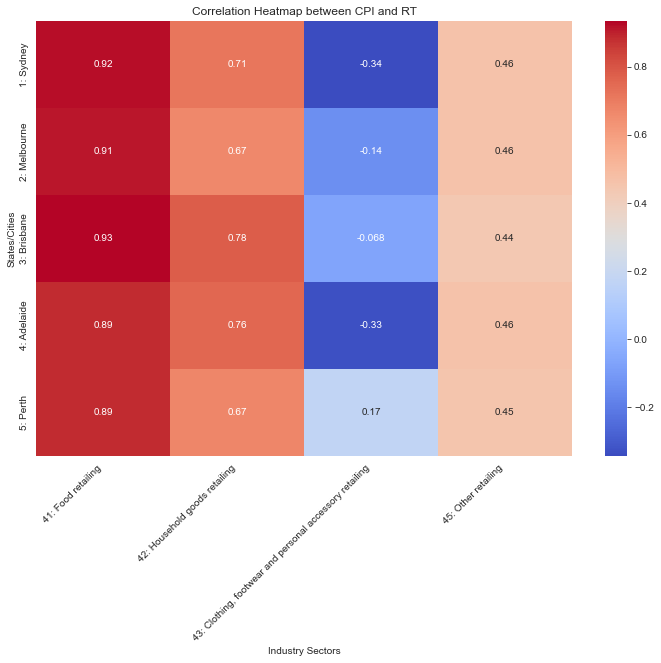

In [35]:
# Filter the data for the selected industry sectors
state_cities = ['1: Sydney', '2: Melbourne', '3: Brisbane', '4: Adelaide', '5: Perth']
industry_sectors = ['41: Food retailing', '42: Household goods retailing',
       '43: Clothing, footwear and personal accessory retailing','45: Other retailing']
# Create a DataFrame to store the correlations
correlation_data = pd.DataFrame(columns=industry_sectors, index=state_cities)

for sector in industry_sectors:
    for city in state_cities:
        subset = merged_df[(merged_df['INDUSTRY'] == sector) & (merged_df['CAPITAL_CITY'] == city)]
        correlation = subset['OBS_VALUE_CPI'].corr(subset['OBS_VALUE_RT'])
        correlation_data.at[city, sector] = correlation

# Set up the figure and axis
plt.figure(figsize=(12, 8))
ax = sns.heatmap(correlation_data.astype(float), annot=True, cmap="coolwarm")

# Rotate x-axis labels by 45 degrees
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

# Set axis labels and title
plt.xlabel("Industry Sectors")
plt.ylabel("States/Cities")
plt.title("Correlation Heatmap between CPI and RT")

plt.savefig('cpi_rt_correlation_matrix.png', dpi=300)
# Show the heatmap
plt.show()

In [31]:
from scipy.stats import ttest_rel

# Create a list of unique state-industry combinations
state_industry_combinations = merged_df[['CAPITAL_CITY', 'INDUSTRY']].drop_duplicates()
significance_level = 0.05
# Perform t-test for each combination
significant_combinations = []
for _, row in state_industry_combinations.iterrows():
    state = row['CAPITAL_CITY']
    industry = row['INDUSTRY']
    
    data = merged_df[(merged_df['CAPITAL_CITY'] == state) & (merged_df['INDUSTRY'] == industry)]
    t_stat, p_value = ttest_rel(data['OBS_VALUE_CPI'], data['OBS_VALUE_RT'])
    
    if p_value > significance_level:
        significant_combinations.append((state, industry))

if len(significant_combinations) == 0:
    print("OBS_VALUE_CPI and OBS_VALUE_RT are uniform over time for all state-industry combinations.")
else:
    print("OBS_VALUE_CPI and OBS_VALUE_RT are not uniform over time for the following state-industry combinations:")
    for state, industry in significant_combinations:
        print(f"- State: {state}, Industry: {industry}")


OBS_VALUE_CPI and OBS_VALUE_RT are uniform over time for all state-industry combinations.


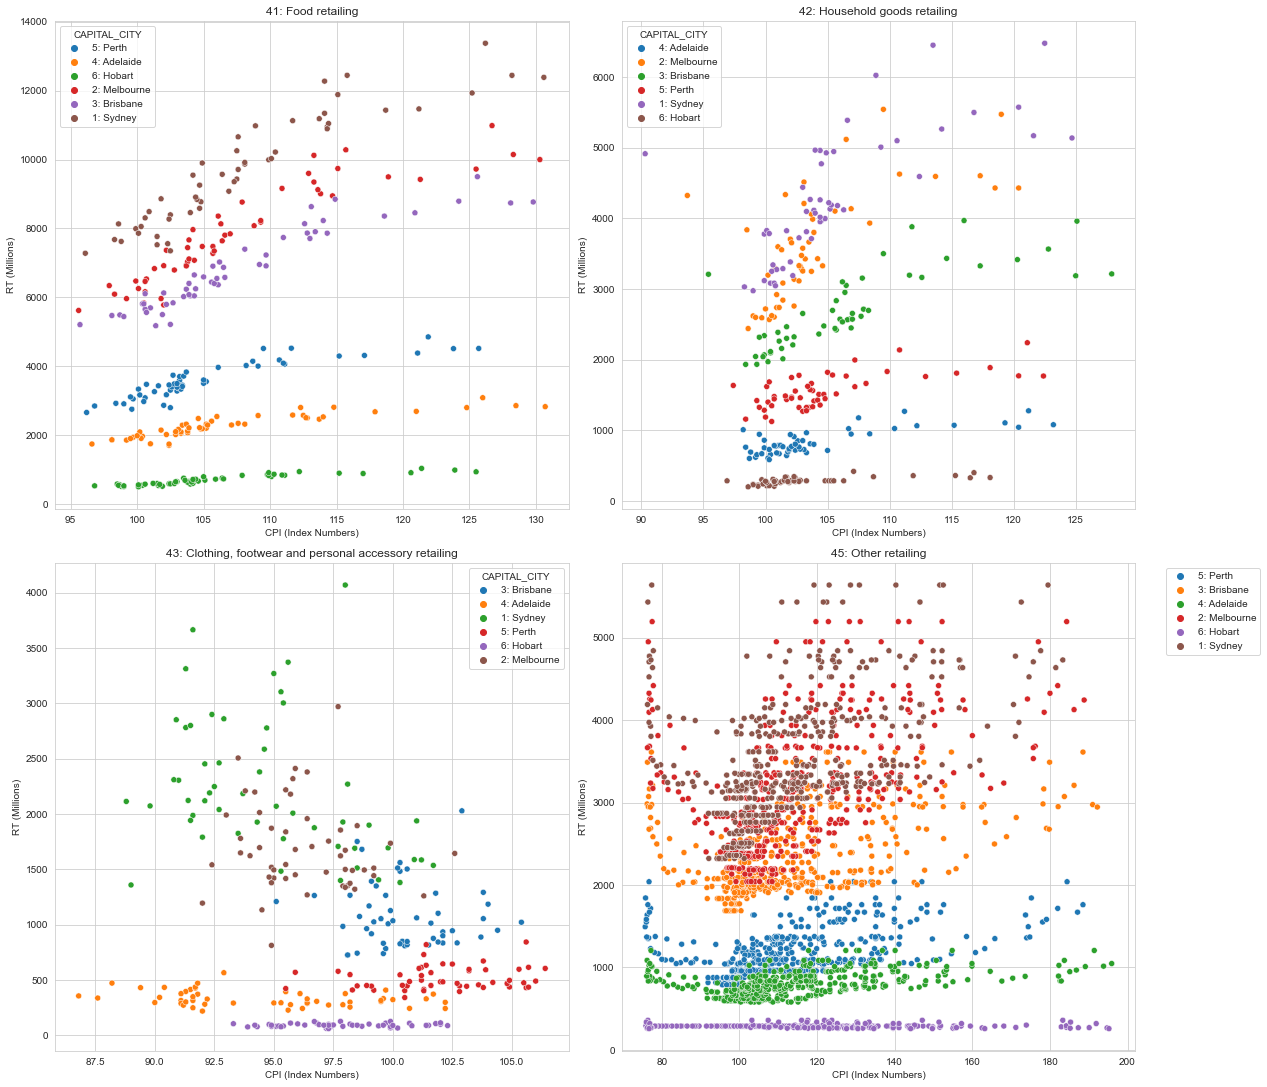

In [34]:
# Filter the data for the selected industry sectors
industry_sectors = ['41: Food retailing','42: Household goods retailing','43: Clothing, footwear and personal accessory retailing', '45: Other retailing']
industry_data = [merged_df[merged_df['INDUSTRY'] == sector] for sector in industry_sectors]

# Set the figure size for the subplot
plt.figure(figsize = (16, 16))  # Adjust the width and height as needed

# Create a 4x4 subplot
for i, data in enumerate(industry_data):
    plt.subplot(2, 2, i+1)
    g = sns.scatterplot(data=data, x='OBS_VALUE_CPI', y='OBS_VALUE_RT', hue='CAPITAL_CITY')
    plt.xlabel("CPI (Index Numbers)")
    plt.ylabel("RT (Millions)")
    plt.title(f"{industry_sectors[i]}")

# Adjust the spacing between subplots
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the layout to leave space for the legend

# Place the legend outside the subplot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.savefig('cpi_rt_scatterplot.png', dpi=300)

# Show the subplot
plt.show()


In [89]:
# Create a figure using Plotly Express with a 2x2 grid of subplots
fig = px.line(merged_df, x='TIME_PERIOD', y=['OBS_VALUE_CPI', 'OBS_VALUE_RT'], color='CAPITAL_CITY',
              facet_col='INDUSTRY', facet_row='CAPITAL_CITY', markers=True,
              labels={'OBS_VALUE_CPI': 'CPI', 'OBS_VALUE_RT': 'Turnover'})

# Update layout to adjust titles, legend placement, and size
fig.update_layout(
    title="Changes in Turnover and CPI Over Time by Industry Sector and State",
    xaxis_title="Time Period",
    yaxis_title="Values",
    width=1600,  # Adjust the width
    height=1200,  # Adjust the height
)

# Show the interactive plot
fig.show()


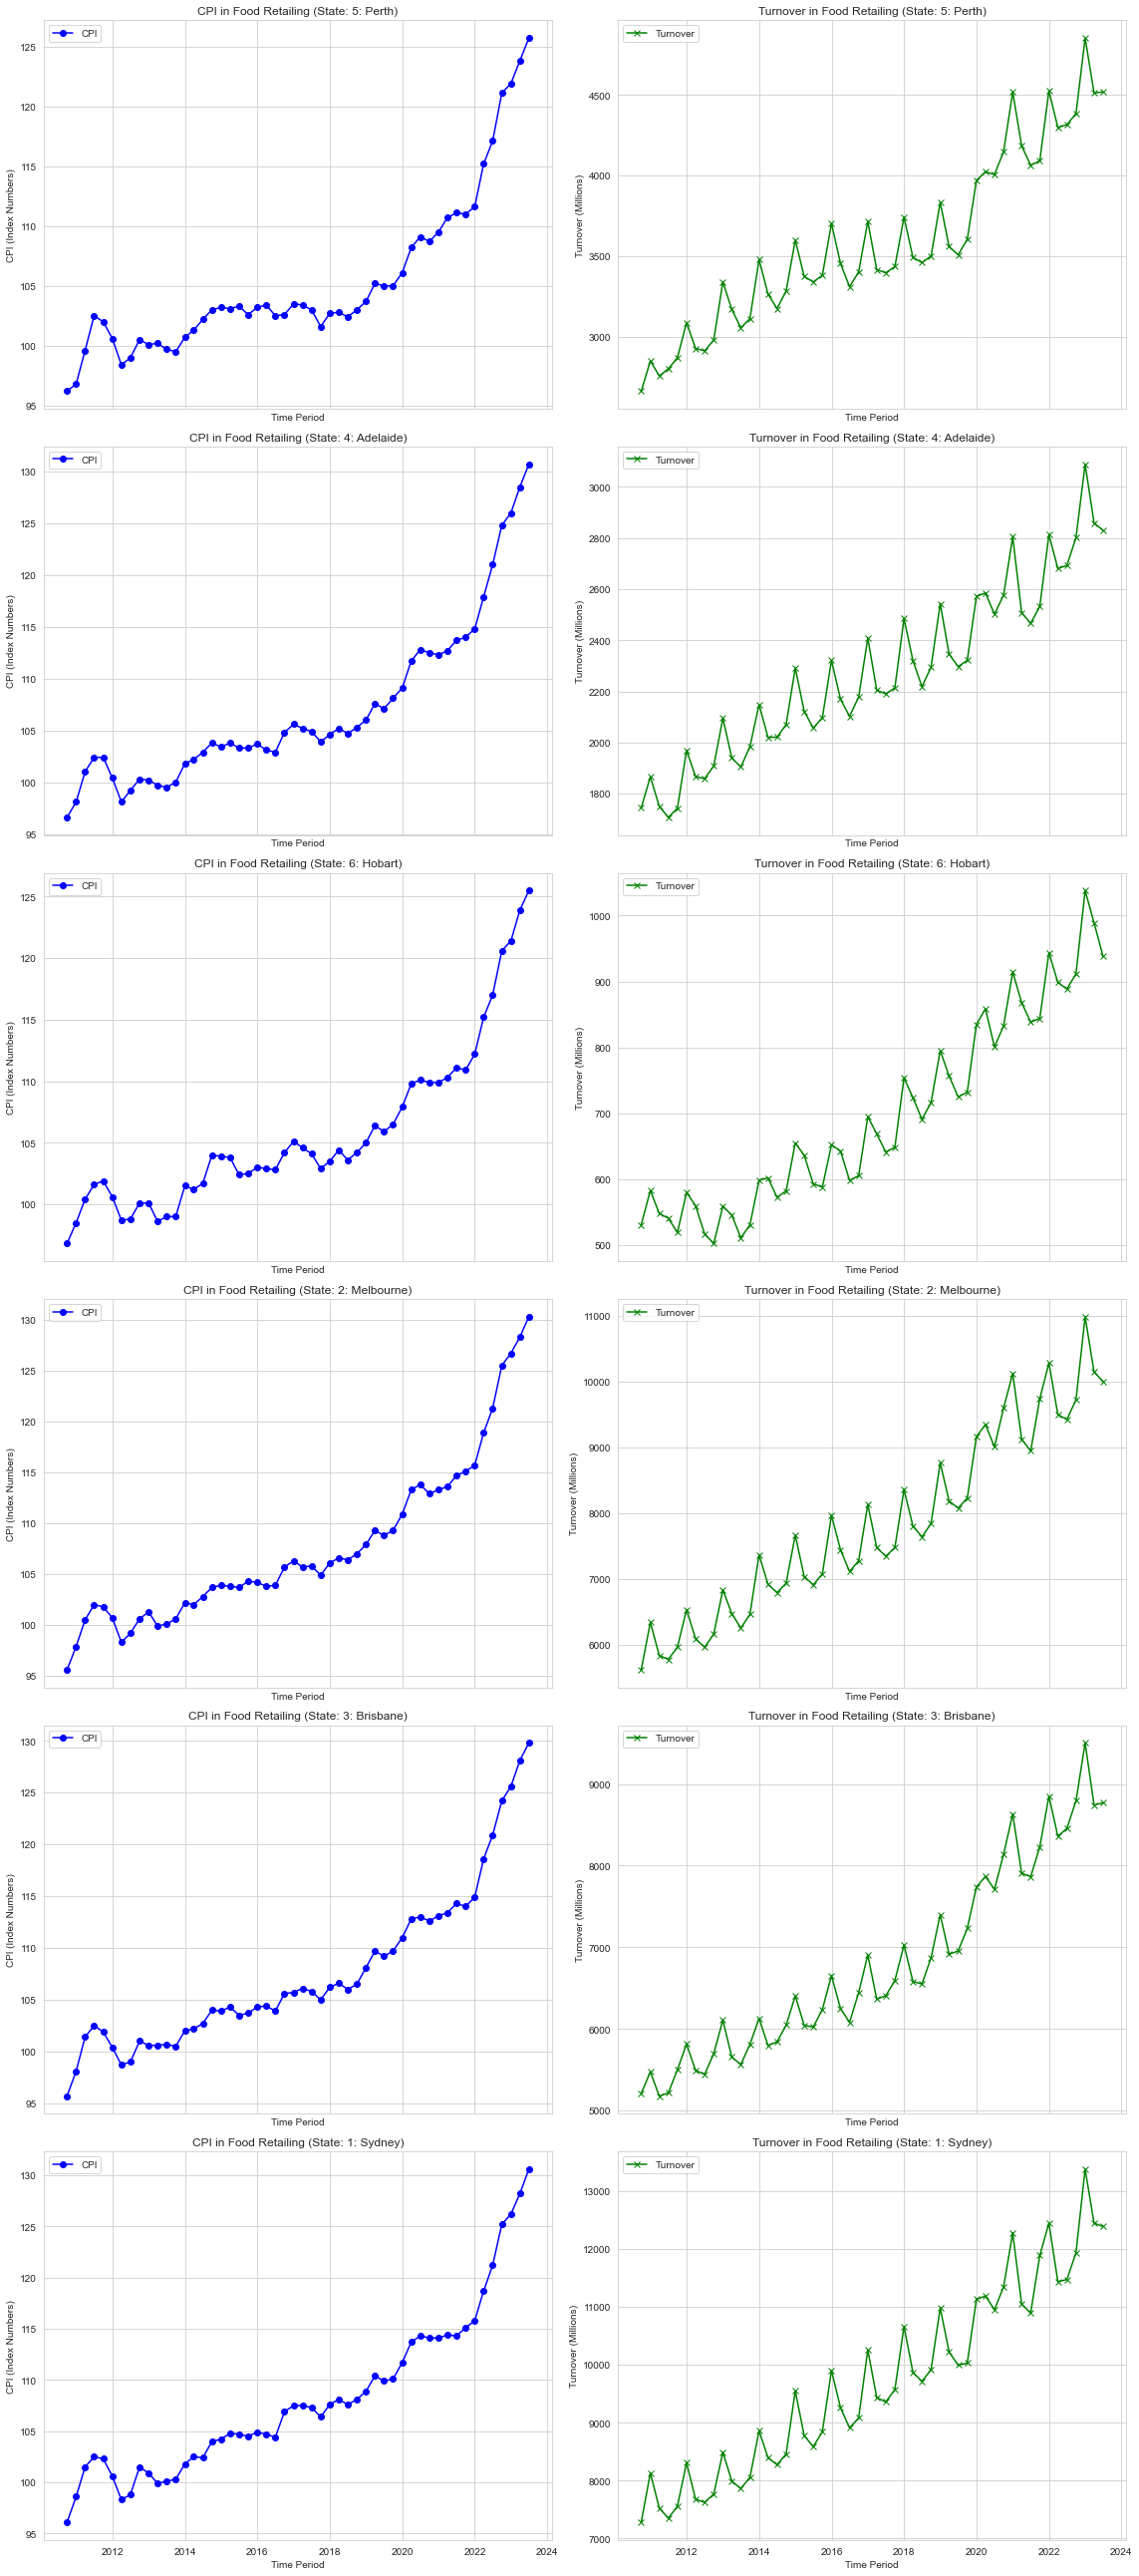

In [78]:
# Filter the data for the "Food Retailing" industry
food_retailing_df = merged_df[merged_df['INDUSTRY'] == '41: Food retailing']

# Get a list of unique states
unique_states = food_retailing_df['CAPITAL_CITY'].unique()

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(len(unique_states), 2, figsize=(16, 6 * len(unique_states)), sharex='col')
plt.subplots_adjust(hspace=0.4, wspace=0.2)

# Plot CPI and Turnover (RT) side by side for each state
for i, state in enumerate(unique_states):
    state_data = food_retailing_df[food_retailing_df['CAPITAL_CITY'] == state]
    
    # Plot CPI on the left subplot (column 0)
    axes[i, 0].plot(state_data['TIME_PERIOD'], state_data['OBS_VALUE_CPI'], label='CPI', marker='o', color='blue')
    axes[i, 0].set_title(f"CPI in Food Retailing (State: {state})")
    axes[i, 0].set_xlabel("Time Period")
    axes[i, 0].set_ylabel("CPI (Index Numbers)")
    axes[i, 0].legend()
    axes[i, 0].grid(True)

    # Plot Turnover (RT) on the right subplot (column 1)
    axes[i, 1].plot(state_data['TIME_PERIOD'], state_data['OBS_VALUE_RT'], label='Turnover', marker='x', color='green')
    axes[i, 1].set_title(f"Turnover in Food Retailing (State: {state})")
    axes[i, 1].set_xlabel("Time Period")
    axes[i, 1].set_ylabel("Turnover (Millions)")
    axes[i, 1].legend()
    axes[i, 1].grid(True)

# Adjust layout for the subplots
plt.tight_layout()

plt.savefig('food_retailing_cpi_rt_subplot.png', dpi=300)

# Show the Matplotlib plots
plt.show()


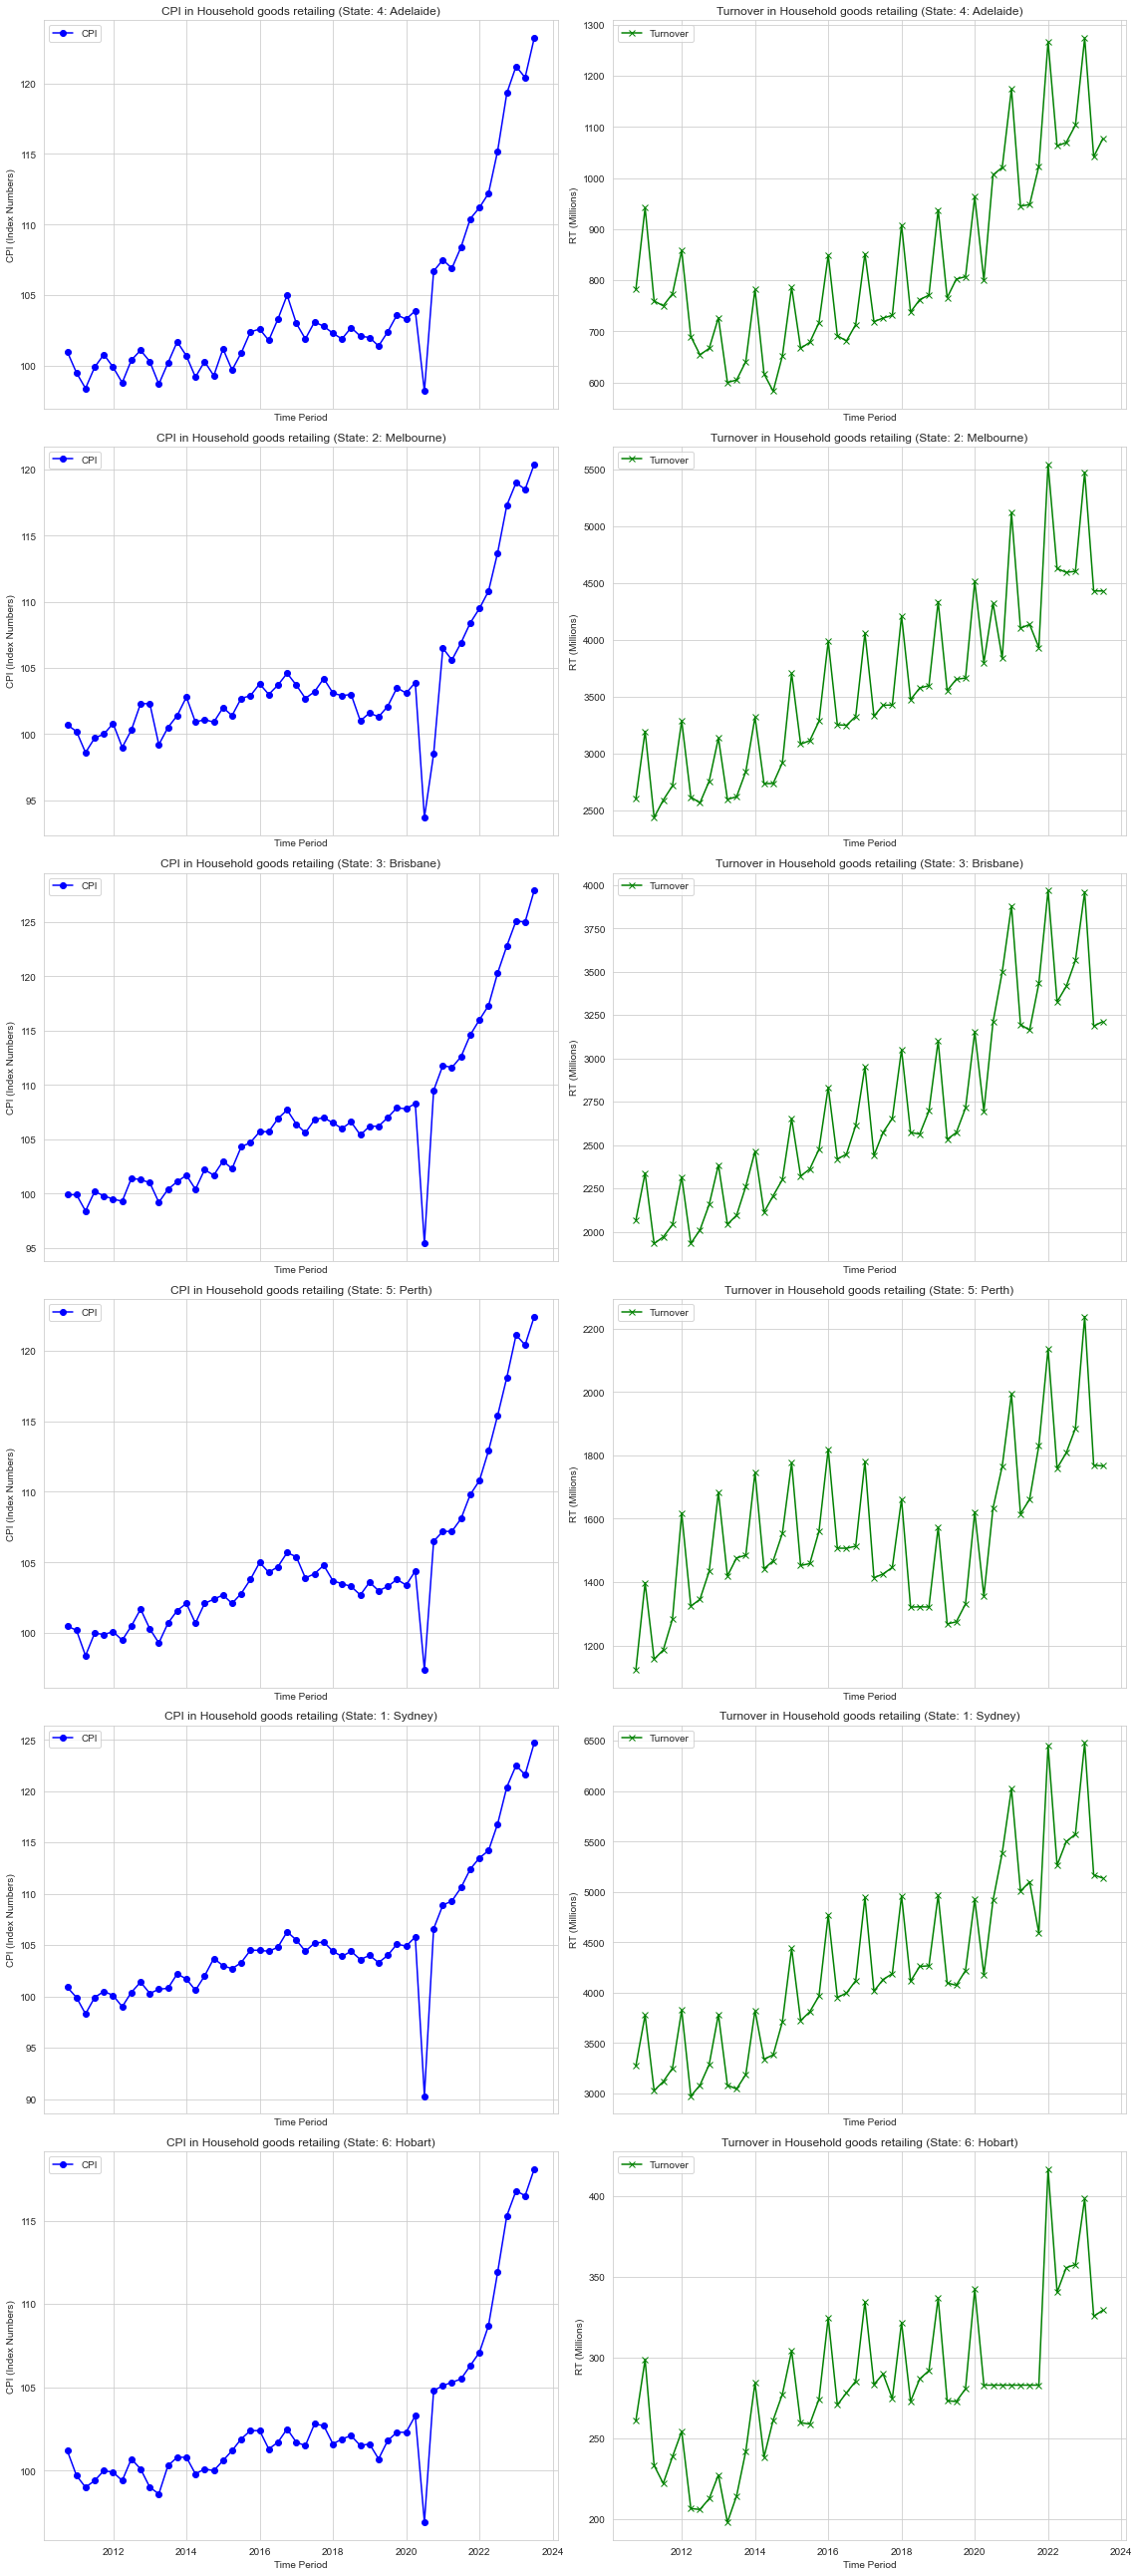

In [79]:
# Filter the data for the "Household goods Retailing" industry
food_retailing_df = merged_df[merged_df['INDUSTRY'] == '42: Household goods retailing']

# Get a list of unique states
unique_states = food_retailing_df['CAPITAL_CITY'].unique()

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(len(unique_states), 2, figsize=(16, 6 * len(unique_states)), sharex='col')
plt.subplots_adjust(hspace=0.4, wspace=0.2)

# Plot CPI and Turnover (RT) side by side for each state
for i, state in enumerate(unique_states):
    state_data = food_retailing_df[food_retailing_df['CAPITAL_CITY'] == state]
    
    # Plot CPI on the left subplot (column 0)
    axes[i, 0].plot(state_data['TIME_PERIOD'], state_data['OBS_VALUE_CPI'], label='CPI', marker='o', color='blue')
    axes[i, 0].set_title(f"CPI in Household goods retailing (State: {state})")
    axes[i, 0].set_xlabel("Time Period")
    axes[i, 0].set_ylabel("CPI (Index Numbers)")
    axes[i, 0].legend()
    axes[i, 0].grid(True)

    # Plot Turnover (RT) on the right subplot (column 1)
    axes[i, 1].plot(state_data['TIME_PERIOD'], state_data['OBS_VALUE_RT'], label='Turnover', marker='x', color='green')
    axes[i, 1].set_title(f"Turnover in Household goods retailing (State: {state})")
    axes[i, 1].set_xlabel("Time Period")
    axes[i, 1].set_ylabel("RT (Millions)")
    axes[i, 1].legend()
    axes[i, 1].grid(True)

# Adjust layout for the subplots
plt.tight_layout()

plt.savefig('Household goods retailing.png', dpi=300)

# Show the Matplotlib plots
plt.show()


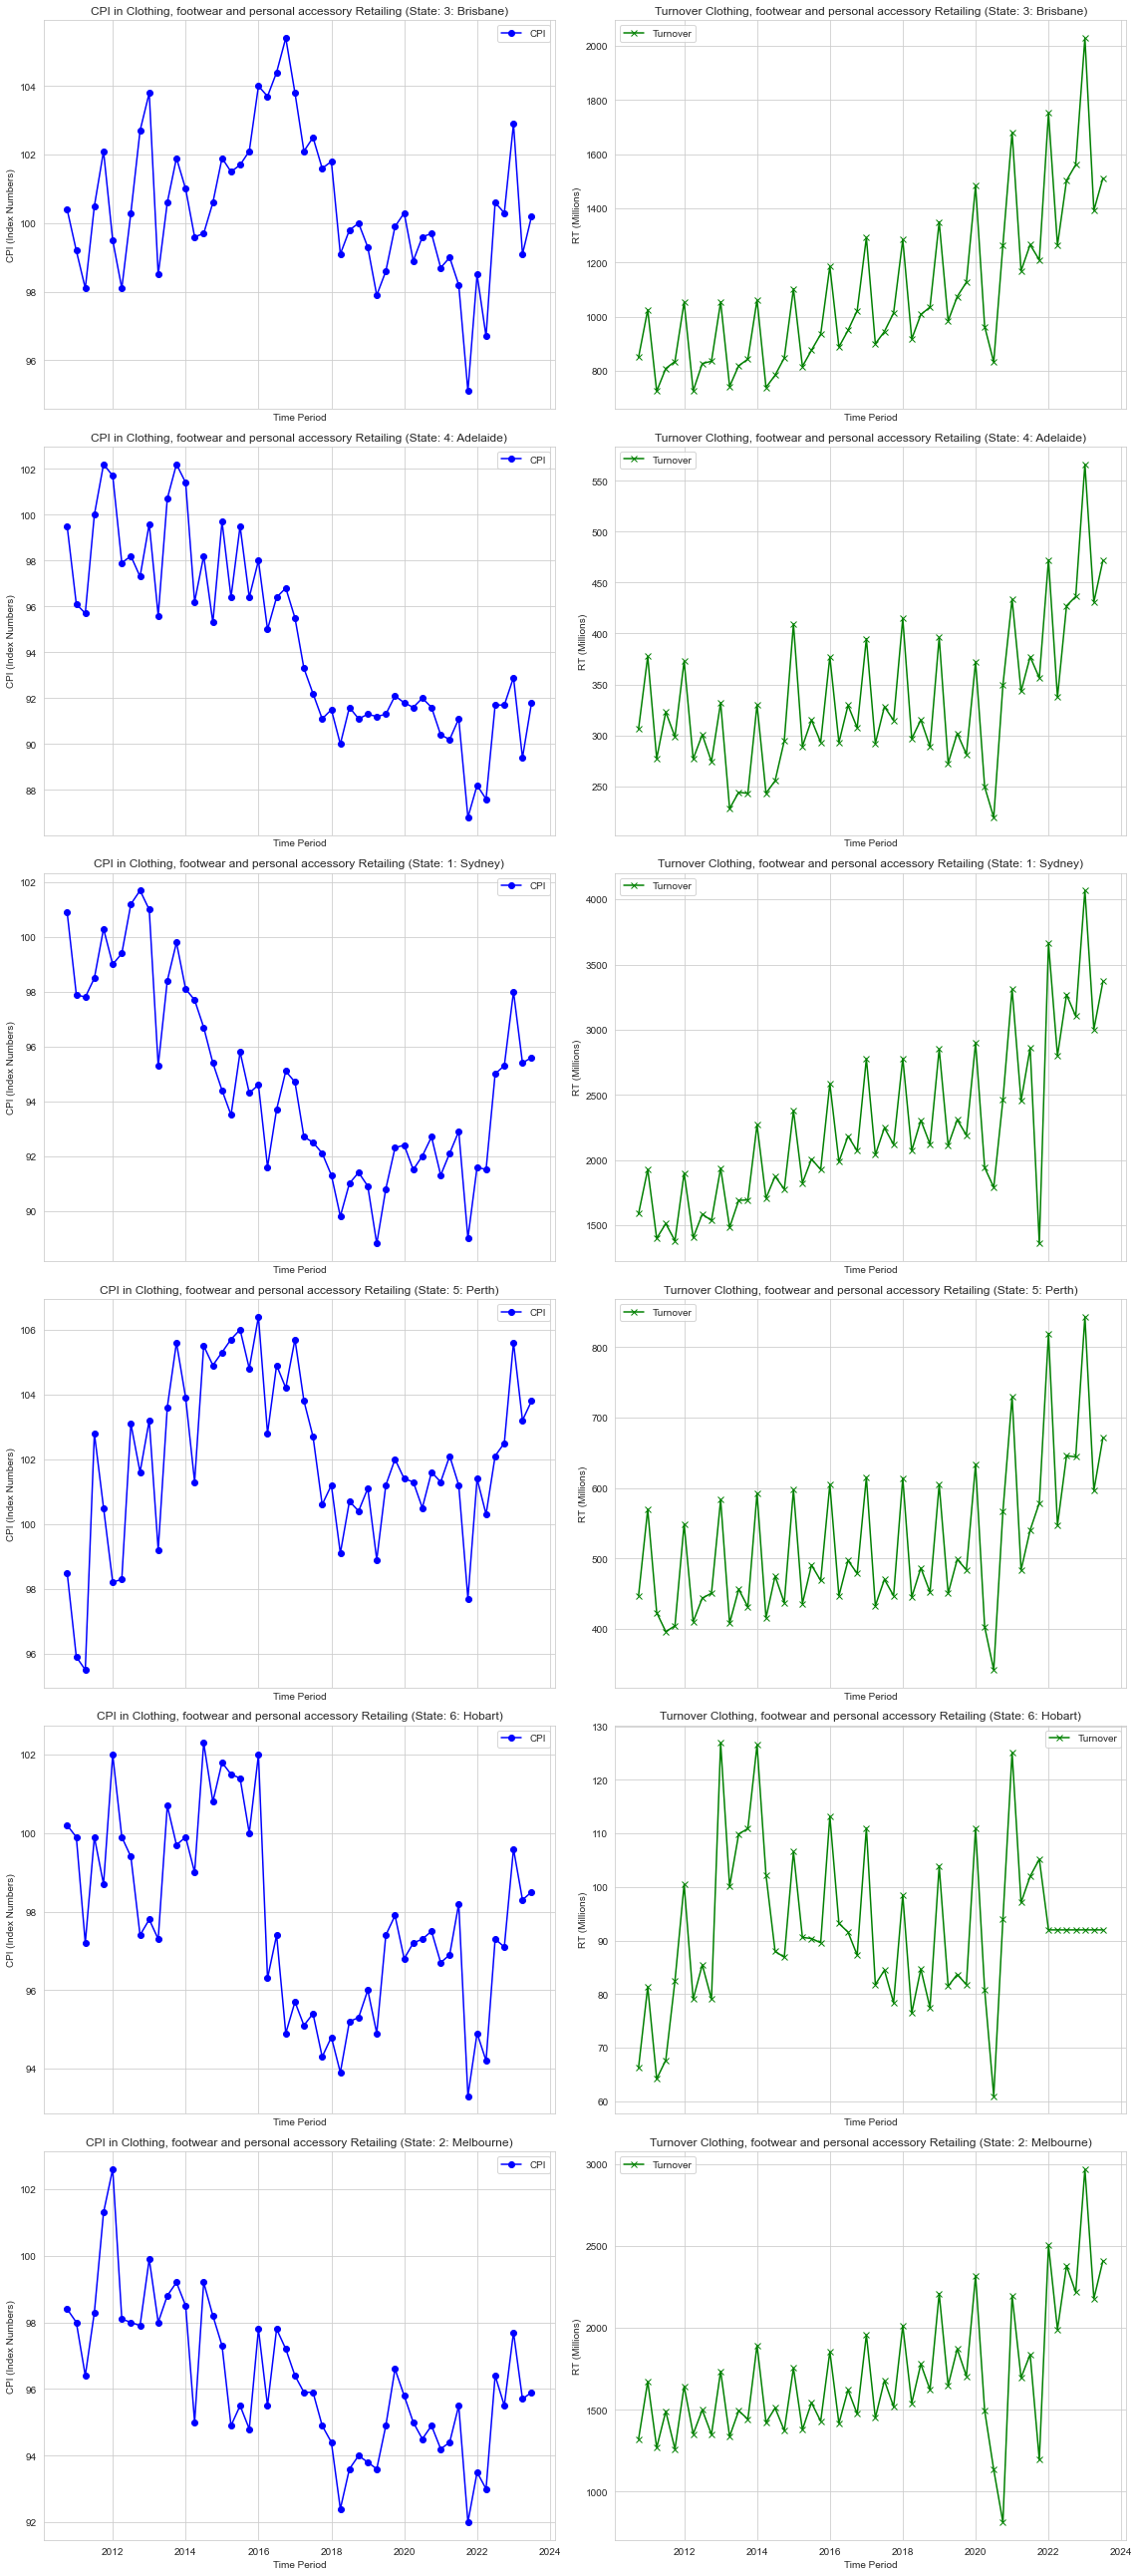

In [80]:
# Filter the data for the "Clothing, footwear and personal accessory Retailing" industry
food_retailing_df = merged_df[merged_df['INDUSTRY'] == '43: Clothing, footwear and personal accessory retailing']

# Get a list of unique states
unique_states = food_retailing_df['CAPITAL_CITY'].unique()

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(len(unique_states), 2, figsize=(16, 6 * len(unique_states)), sharex='col')
plt.subplots_adjust(hspace=0.4, wspace=0.2)

# Plot CPI and Turnover (RT) side by side for each state
for i, state in enumerate(unique_states):
    state_data = food_retailing_df[food_retailing_df['CAPITAL_CITY'] == state]
    
    # Plot CPI on the left subplot (column 0)
    axes[i, 0].plot(state_data['TIME_PERIOD'], state_data['OBS_VALUE_CPI'], label='CPI', marker='o', color='blue')
    axes[i, 0].set_title(f"CPI in Clothing, footwear and personal accessory Retailing (State: {state})")
    axes[i, 0].set_xlabel("Time Period")
    axes[i, 0].set_ylabel("CPI (Index Numbers)")
    axes[i, 0].legend()
    axes[i, 0].grid(True)

    # Plot Turnover (RT) on the right subplot (column 1)
    axes[i, 1].plot(state_data['TIME_PERIOD'], state_data['OBS_VALUE_RT'], label='Turnover', marker='x', color='green')
    axes[i, 1].set_title(f"Turnover Clothing, footwear and personal accessory Retailing (State: {state})")
    axes[i, 1].set_xlabel("Time Period")
    axes[i, 1].set_ylabel("RT (Millions)")
    axes[i, 1].legend()
    axes[i, 1].grid(True)

# Adjust layout for the subplots
plt.tight_layout()

plt.savefig('Clothing, footwear and personal accessory retailing.png', dpi=300)

# Show the Matplotlib plots
plt.show()


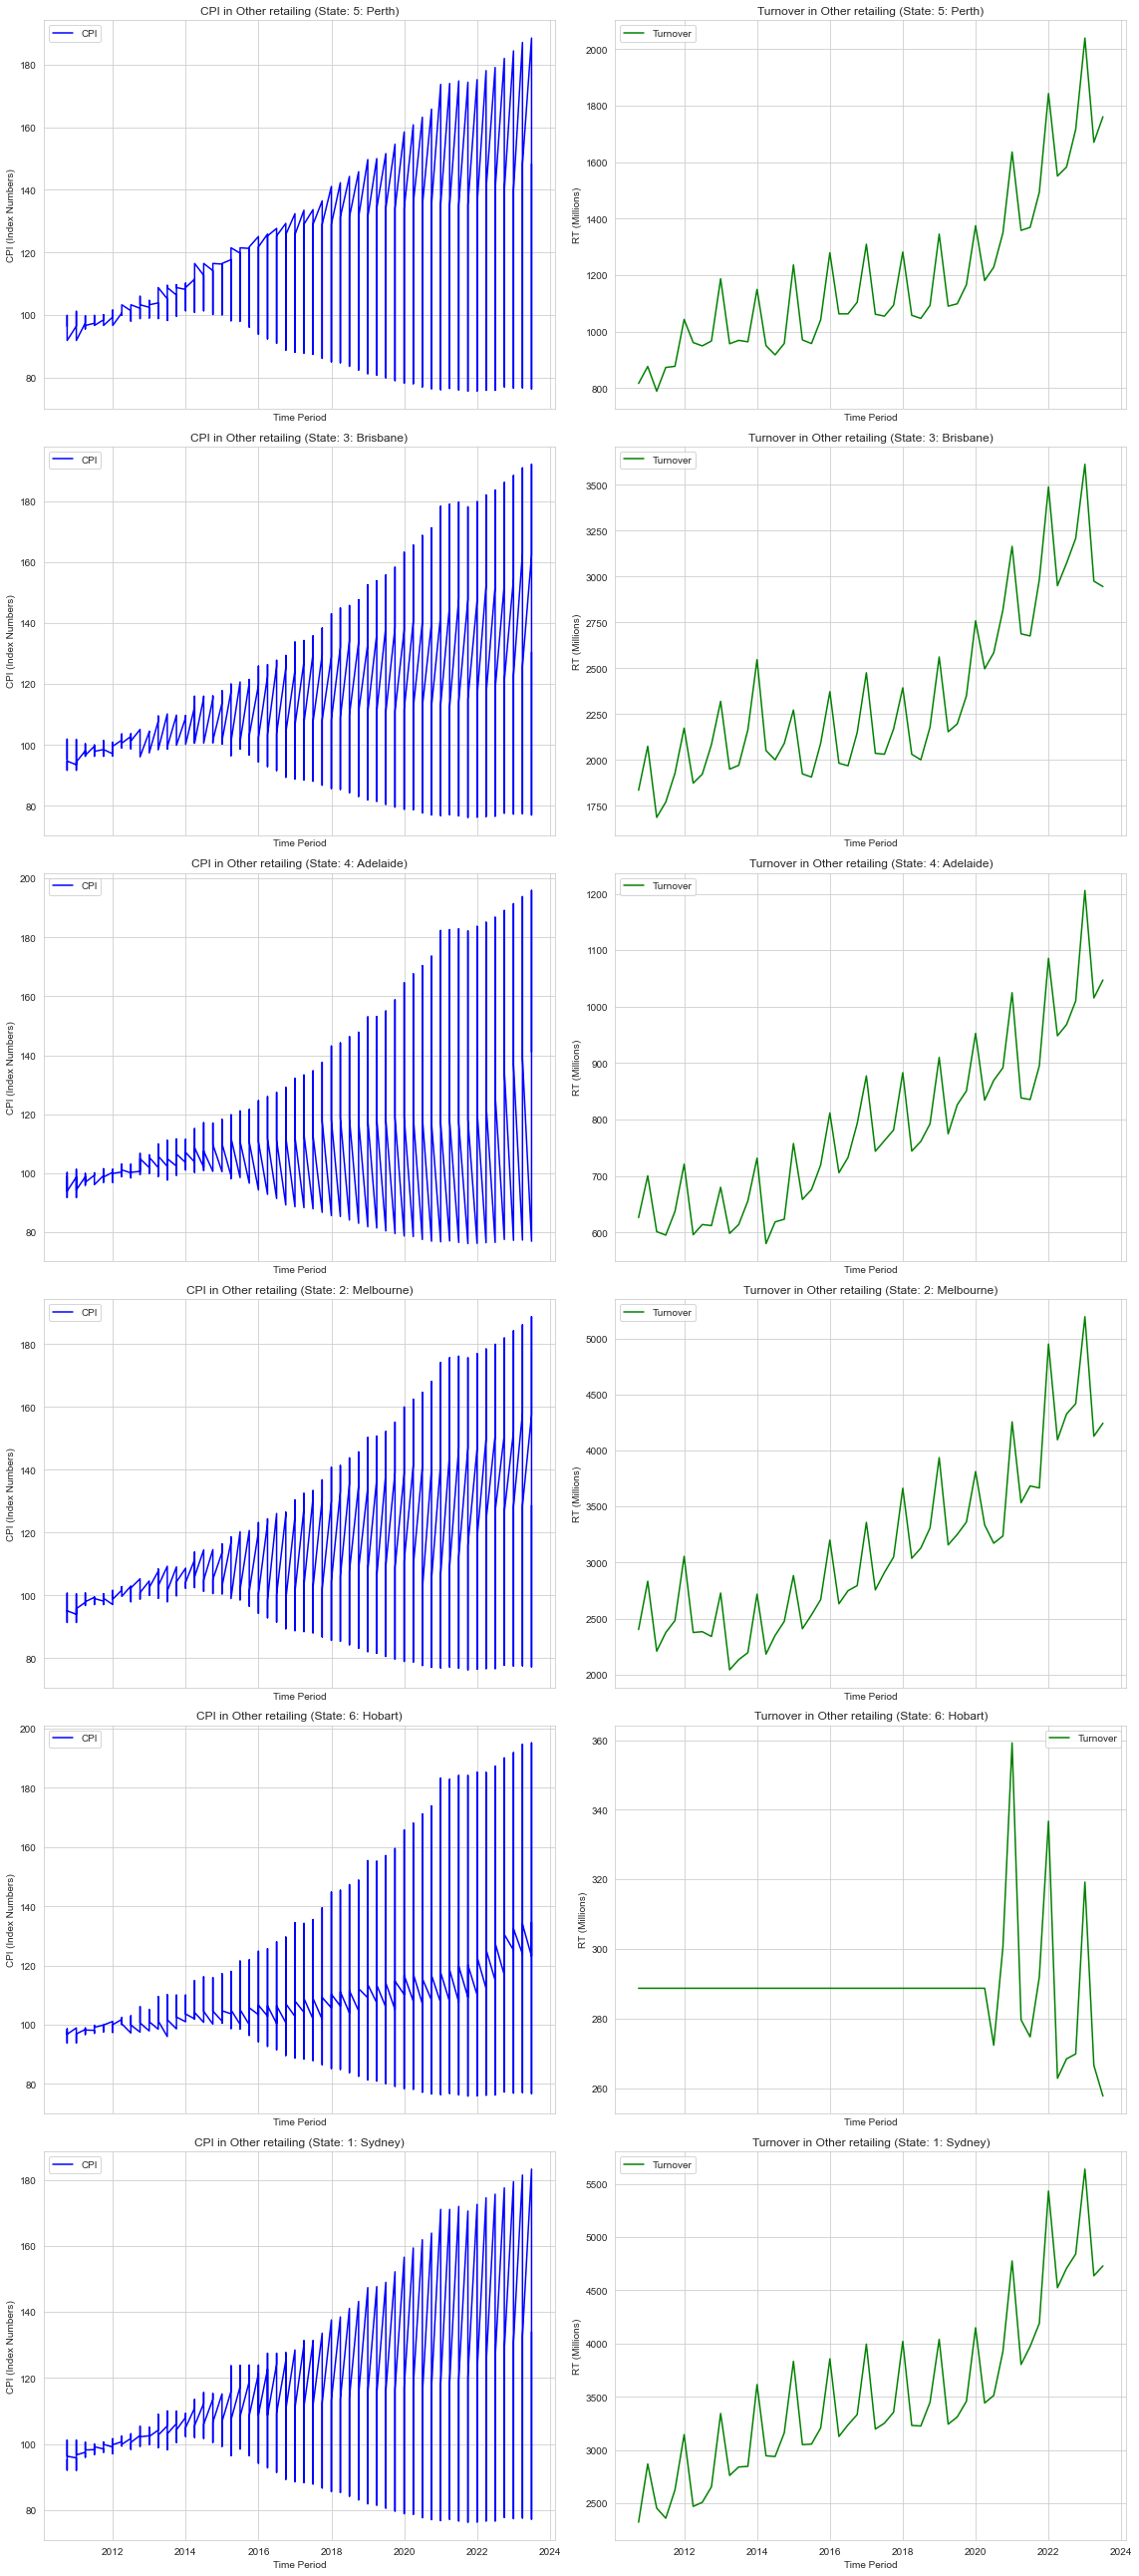

In [81]:
# Filter the data for the "Other Retailing" industry
food_retailing_df = merged_df[merged_df['INDUSTRY'] == '45: Other retailing']

# Get a list of unique states
unique_states = food_retailing_df['CAPITAL_CITY'].unique()

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(len(unique_states), 2, figsize=(16, 6 * len(unique_states)), sharex='col')
plt.subplots_adjust(hspace=0.4, wspace=0.2)

# Plot CPI and Turnover (RT) side by side for each state
for i, state in enumerate(unique_states):
    state_data = food_retailing_df[food_retailing_df['CAPITAL_CITY'] == state]
    
    # Plot CPI on the left subplot (column 0)
    axes[i, 0].plot(state_data['TIME_PERIOD'], state_data['OBS_VALUE_CPI'], label='CPI', color='blue')
    axes[i, 0].set_title(f"CPI in Other retailing (State: {state})")
    axes[i, 0].set_xlabel("Time Period")
    axes[i, 0].set_ylabel("CPI (Index Numbers)")
    axes[i, 0].legend()
    axes[i, 0].grid(True)

    # Plot Turnover (RT) on the right subplot (column 1)
    axes[i, 1].plot(state_data['TIME_PERIOD'], state_data['OBS_VALUE_RT'], label='Turnover', color='green')
    axes[i, 1].set_title(f"Turnover in Other retailing (State: {state})")
    axes[i, 1].set_xlabel("Time Period")
    axes[i, 1].set_ylabel("RT (Millions)")
    axes[i, 1].legend()
    axes[i, 1].grid(True)

# Adjust layout for the subplots
plt.tight_layout()

plt.savefig('Other retailing.png', dpi=300)

# Show the Matplotlib plots
plt.show()
